Забираем подготовленные данные

In [81]:
# !pip install torch

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, Model
import os
import numpy as np
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error

In [83]:
def set_seed(seed=42):
    """Фиксирует все random seeds для воспроизводимости"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # если используете multi-GPU
    
    # Для детерминированных алгоритмов в PyTorch (может замедлить работу)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Для воспроизводимости в DataLoader
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(55)

In [84]:
# print("GPU доступны:", tf.config.list_physical_devices('GPU'))
# print("Версия TensorFlow:", tf.__version__)
# print("CUDA доступна:", tf.test.is_built_with_cuda())

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA version: 12.8


In [85]:
train = pd.read_excel('.//data//prepared_data.xlsx',sheet_name="Train")

In [86]:
# Кластеризация по целевому показателю "Шкала"
def cluster_by_target(train: pd.DataFrame, target_col: str = 'Шкала', n_clusters: int = 3):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train[[target_col]])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    train['cluster'] = kmeans.fit_predict(X_scaled)
    
    return train, kmeans

# Определение кластера с наибольшим средним значением целевого показателя
def get_highest_mean_cluster(train: pd.DataFrame, target_col: str = 'Шкала'):
    cluster_means = train.groupby('cluster')[target_col].mean()
    top_cluster = cluster_means.idxmax()
    return top_cluster

# Определение наиболее похожих столбцов внутри кластера
def find_similar_features(train: pd.DataFrame, cluster_label: int, n_features: int = 5):
    cluster_data = train[train['cluster'] == cluster_label]
    numeric_data = cluster_data.select_dtypes(include=[np.number]).drop(columns=['cluster'])

    corr = numeric_data.corr()
    mean_corr = corr.abs().mean().sort_values(ascending=False)
    top_features = mean_corr.head(n_features).index.tolist()

    return top_features, numeric_data[top_features]

# Генерация новых данных без загрязнения (комбинирование малозначимых и значимых признаков)
def generate_balanced_data(train: pd.DataFrame, cluster_label: int, top_features: list, n_samples: int = 100):
    cluster_data = train[train['cluster'] == cluster_label]
    
    # Разделим признаки по значимости
    significant = cluster_data[top_features]
    less_significant = cluster_data.drop(columns=['cluster'] + top_features)
    
    new_data = []
    for _ in range(n_samples):
        sig_sample = significant.sample(1, replace=True).values[0]
        less_sample = less_significant.sample(1, replace=True).values[0]
        combined = np.concatenate([sig_sample, less_sample])
        new_data.append(combined)

    new_df = pd.DataFrame(new_data, columns=top_features + list(less_significant.columns))
    new_df['cluster'] = cluster_label
    return new_df

'''
К сожалению, решить задачу без аугментаций оказалось проблематично, поэтому было решено расширить общий список 
данных набором сгенерированных на его основе экземпляров. За основу будут браться столбцы из кластеров с наибольшим 
значением целевого показателя.
'''
train, model = cluster_by_target(train, 'Шкала')
top_cluster = get_highest_mean_cluster(train, 'Шкала')
top_features, _ = find_similar_features(train, top_cluster, n_features=5)
new_data = generate_balanced_data(train, top_cluster, top_features, n_samples=80)
balanced_train = pd.concat([train, new_data], ignore_index=True)

balanced_train = balanced_train.drop(columns='cluster').copy()


x_train = balanced_train.drop(columns='Шкала').copy()
y_train = balanced_train[["Шкала"]]

balanced_train.info(verbose=True, show_counts=True) # Просмотр типов данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 157 columns):
 #    Column                                   Non-Null Count  Dtype  
---   ------                                   --------------  -----  
 0    ВозрастОбсл                              730 non-null    float64
 1    КолОфБрак                                730 non-null    float64
 2    КолДети                                  730 non-null    float64
 3    Наследственность_ДиагнозНеИзвестен       730 non-null    float64
 4    РЛ                                       730 non-null    float64
 5    Завершенный_суицид                       730 non-null    float64
 6    Суицидальные_попытки                     730 non-null    float64
 7    соматика                                 730 non-null    float64
 8    Рост                                     730 non-null    float64
 9    Вес                                      730 non-null    float64
 10   АртДавление_в                       

In [87]:
test = pd.read_excel('.//data//prepared_data.xlsx',sheet_name="Test")
x_test = test.drop(columns='Шкала').copy()
y_test = test[["Шкала"]]
test.info(verbose=True, show_counts=True) # Просмотр типов данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 157 columns):
 #    Column                                   Non-Null Count  Dtype  
---   ------                                   --------------  -----  
 0    ВозрастОбсл                              163 non-null    float64
 1    КолОфБрак                                163 non-null    float64
 2    КолДети                                  163 non-null    float64
 3    Наследственность_ДиагнозНеИзвестен       163 non-null    float64
 4    РЛ                                       163 non-null    float64
 5    Завершенный_суицид                       163 non-null    float64
 6    Суицидальные_попытки                     163 non-null    float64
 7    соматика                                 163 non-null    float64
 8    Рост                                     163 non-null    float64
 9    Вес                                      163 non-null    float64
 10   АртДавление_в                       

In [88]:
attention_hidden = 128 # Размер вектора эмбеддингов для механизма внимания 

In [89]:
# Преобразование в numpy array
def ensure_numpy(x):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        return x.to_numpy()
    if isinstance(x, list):
        return np.array(x)
    if isinstance(x, np.ndarray):
        return x
    raise ValueError(f"Unsupported input type: {type(x)}")

# Дополнительно предобрабатываем данные 
def prepare_data(x_train, x_test, scaler=None):
    x_train = ensure_numpy(x_train).astype(np.float32)
    x_test = ensure_numpy(x_test).astype(np.float32)

    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(x_train)

    x_train_s = scaler.transform(x_train)
    x_test_s = scaler.transform(x_test)
    return x_train_s, x_test_s, scaler


# Базовый класс для слоя с вниманием
class FeatureAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, temperature_init=1.0):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.log_temp = nn.Parameter(torch.log(torch.tensor(temperature_init)))
        self.layernorm = nn.LayerNorm(input_dim)

    def forward(self, x):
        batch_size, feature_dim = x.shape
        x_expanded = x.unsqueeze(-1) 
        h = torch.tanh(self.fc1(x_expanded))
        scores = self.fc2(h).squeeze(-1)  
        temp = F.softplus(self.log_temp) + 1e-6 
        weights = F.softmax(scores / temp, dim=1)
        attended = x * weights
        attended = self.layernorm(attended + x)
        return attended, weights

# Сделаем MultiHeadFeatureAttention для более глубокого анализа входящих данных
class MultiHeadFeatureAttention(nn.Module):
    def __init__(self, input_dim, num_heads=4, hidden_dim=32):
        super().__init__()
        self.num_heads = num_heads
        self.heads = nn.ModuleList([
            FeatureAttention(input_dim, hidden_dim) for _ in range(num_heads)
        ])
        self.proj = nn.Linear(input_dim * num_heads, input_dim)
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        attended_list = []
        weights_list = []
        for head in self.heads:
            attended, weights = head(x)
            attended_list.append(attended)         
            weights_list.append(weights)           
        concat = torch.cat(attended_list, dim=-1)  
        attended_out = self.proj(concat)          
        attended_out = self.norm(attended_out)
        weights_mean = torch.stack(weights_list, dim=0).mean(0)
        return attended_out, weights_mean

"""
Изначально предполагалось решать задачу регрессии (из-за чего первая часть работы на выходе имеет не векторы классов, а float значения)
Но в результате тестирования разных моделей, лучше всего себя показал ваиант с FeatureAttention, а зтаем и MultiHeadFeatureAttention.
К сожалению, результат оказывался неудволетворительным, и было принято решение перейти на вариант задачи классификации
"""

class AttentionRegressor(nn.Module):
    def __init__(self, input_dim, attention_hidden=64, mlp_layers=(512, 256, 128), dropout=0.4):
        super().__init__()

        # Embedding layer before attention
        self.preprocess = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        # Multi-head attention
        self.attn = MultiHeadFeatureAttention(128, num_heads=4, hidden_dim=attention_hidden)

        # MLP with skip connection
        layers = []
        prev_dim = 128 * 2
        for units in mlp_layers:
            layers.append(nn.Linear(prev_dim, units))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm(units))
            layers.append(nn.Dropout(dropout))
            prev_dim = units
        self.mlp = nn.Sequential(*layers)
        self.output = nn.Linear(prev_dim, 1)
        self.skip_proj = nn.Linear(prev_dim, 128)  # или наоборот, в конце mlp

    def forward(self, x):
        x_emb = self.preprocess(x)
        attended, weights = self.attn(x_emb)
        x_cat = torch.cat([x_emb, attended], dim=-1)
        h = self.mlp(x_cat)
        h = h + self.skip_proj(x_emb)
        # skip connection если совпадают размеры
        if h.shape[1] == x_emb.shape[1]:
            h = h + x_emb
        out = self.output(h)
        return out.squeeze(-1), weights


# Старая функция обучения
def train_model(model, train_loader, val_loader, epochs=100, lr=1e-4, device="cpu", out_dir="./artifacts"):
    os.makedirs(out_dir, exist_ok=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    criterion = nn.SmoothL1Loss()

    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": [], "train_mae": [], "val_mae": []}
    print(len(train_loader))
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_mae = 0.0, 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds, _ = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            train_mae += torch.mean(torch.abs(preds - yb)).item() * xb.size(0)

        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)

        model.eval()
        val_loss, val_mae = 0.0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds, _ = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_mae += torch.mean(torch.abs(preds - yb)).item() * xb.size(0)

        
        scheduler.step(val_loss)
        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_mae"].append(train_mae)
        history["val_mae"].append(val_mae)

        print(f"Epoch {epoch:03d}/{epochs} - train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_mae={val_mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(out_dir, "best_model.pt"))

    torch.save(model.state_dict(), os.path.join(out_dir, "last_model.pt"))

    plot_history(history, out_dir)
    return history

def plot_history(history, out_dir="./artifacts"):
    plt.figure(figsize=(8, 5))
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Loss during training")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "loss.png"))
    plt.close()

    plt.figure(figsize=(8, 5))
    plt.plot(history["train_mae"], label="train_mae")
    plt.plot(history["val_mae"], label="val_mae")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.title("MAE during training")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "mae.png"))
    plt.close()

# Создаем модель классификатора
class AttentionClassifier(nn.Module):
    def __init__(self, input_dim, attention_hidden=64, mlp_layers=(512, 256, 128), 
                 dropout=0.4, num_bins=10):
        super().__init__()
        self.num_bins = num_bins
        
        self.preprocess = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )
        
        self.attn = MultiHeadFeatureAttention(128, num_heads=4, hidden_dim=attention_hidden)
        
        layers = []
        prev_dim = 128 * 2
        for units in mlp_layers:
            layers.append(nn.Linear(prev_dim, units))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm(units))
            layers.append(nn.Dropout(dropout))
            prev_dim = units
        
        self.mlp = nn.Sequential(*layers)
        self.output = nn.Linear(prev_dim, num_bins)
        self.skip_proj = nn.Linear(prev_dim, 128)

    def forward(self, x):
        x_emb = self.preprocess(x)
        attended, weights = self.attn(x_emb)
        x_cat = torch.cat([x_emb, attended], dim=-1)
        h = self.mlp(x_cat)
        h = h + self.skip_proj(x_emb)
        
        if h.shape[1] == x_emb.shape[1]:
            h = h + x_emb
            
        logits = self.output(h)
        return logits, weights

# Функция для преобразования логитов в регрессионные предсказания
def logits_to_regression(logits, bins):
    probabilities = F.softmax(logits, dim=1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_tensor = torch.tensor(bin_centers, dtype=torch.float32).to(logits.device)
    regression_pred = torch.sum(probabilities * bin_centers_tensor, dim=1)
    return regression_pred

# Модифицированная функция обучения для классификации
def train_classifier_model(model, train_loader, val_loader, bins, class_weights, epochs=100, lr=1e-4, device="cpu", out_dir="./artifacts"):
    os.makedirs(out_dir, exist_ok=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # Используем такой шедулер, потому что быстро выходим на плато

    # Используем CrossEntropyLoss с весами классов
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": [], "train_mae": [], "val_mae": []}
    
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_mae = 0.0, 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)                               # Перемещаем данные на GPU
            optimizer.zero_grad()                                               # Готовим оптимизатор к новым вычислениям
            logits, _ = model(xb)                                               # Делаем предсказания
            loss = criterion(logits, yb)                                        # Оцениваем качество предсказаний
            loss.backward()                                                     # Вычисляем, как нужно изменить веса
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)    # Стабилизируем обучение
            optimizer.step()                                                    # обновляем веса
            
            # Для метрик преобразуем обратно в регрессию
            with torch.no_grad():
                preds_regression = logits_to_regression(logits, bins)
                # Получаем оригинальные значения y для MAE 
                yb_original = torch.tensor((bins[yb.cpu().numpy()] + bins[yb.cpu().numpy() + 1]) / 2, 
                                          dtype=torch.float32).to(device)
                train_mae += torch.mean(torch.abs(preds_regression - yb_original)).item() * xb.size(0)
            
            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)

        model.eval()
        val_loss, val_mae = 0.0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits, _ = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)
                
                # Для валидационных метрик
                preds_regression = logits_to_regression(logits, bins)
                yb_original = torch.tensor((bins[yb.cpu().numpy()] + bins[yb.cpu().numpy() + 1]) / 2, 
                                          dtype=torch.float32).to(device)
                val_mae += torch.mean(torch.abs(preds_regression - yb_original)).item() * xb.size(0)

        scheduler.step(val_loss)
        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_mae"].append(train_mae)
        history["val_mae"].append(val_mae)

        print(f"Epoch {epoch:03d}/{epochs} - train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_mae={val_mae:.4f}")

        if val_mae < best_val_loss:
            best_val_loss = val_mae
            torch.save(model.state_dict(), os.path.join(out_dir, "best_model.pt"))

    torch.save(model.state_dict(), os.path.join(out_dir, "last_model.pt"))
    plot_history(history, out_dir)
    return history, bins


# Функция для предсказания на тестовых данных
def load_and_predict_classifier(model_path, x_test, y_test, bins, device="cpu"):
    """
    Загружает обученную модель-классификатор и предсказывает на тестовых данных
    """
    x_test = ensure_numpy(x_test).astype(np.float32)
    y_test = ensure_numpy(y_test).astype(np.float32).reshape(-1)

    # Загружаем модель
    input_dim = x_test.shape[1]
    model = AttentionClassifier(input_dim=input_dim, attention_hidden=attention_hidden, num_bins=len(bins)-1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    with torch.no_grad():
        x_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
        logits, _ = model(x_tensor)
        preds = logits_to_regression(logits, bins).cpu().numpy()

    mape = mean_absolute_percentage_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)

    df = pd.DataFrame({
        "original": y_test,
        "predicted": preds,
        "diff": y_test - preds
    })

    print(f"Test Results - MAPE: {mape:.6f}, R2: {r2:.6f}, MAE: {mae:.6f}, MSE: {mse:.6f}")
    df["mape"] = mape
    df["r2"] = r2
    df["mae"] = mae
    df["mse"] = mse

    return df, preds



Shapes after split: x_tr (620, 156) y_tr (620, 1) x_val (110, 156) y_val (110, 1)
Number of bins: 20
Bin counts: [189  91  53  44  49  30  24  11  23  12  18   8  22   9  19   9   2   0
   1   6]
Class weights shape: (20,)
Class weights: [0.27068782 0.37877233 0.48212283 0.52297911 0.49900376 0.6163179
 0.67673232 0.92480358 0.68877607 0.89425161 0.76145406 1.04273372
 0.70153574 0.99800751 0.74493475 0.99800751 1.65355299 3.99203005
 1.99601503 1.15728132]
Epoch 001/130 - train_loss=2.3006 val_loss=2.0158 val_mae=0.1837
Epoch 002/130 - train_loss=1.1900 val_loss=2.0395 val_mae=0.1011
Epoch 003/130 - train_loss=0.7869 val_loss=1.9998 val_mae=0.0791
Epoch 004/130 - train_loss=0.4979 val_loss=2.3927 val_mae=0.0725
Epoch 005/130 - train_loss=0.3935 val_loss=1.9373 val_mae=0.0629
Epoch 006/130 - train_loss=0.2542 val_loss=2.2247 val_mae=0.0659
Epoch 007/130 - train_loss=0.1976 val_loss=2.3945 val_mae=0.0629
Epoch 008/130 - train_loss=0.1395 val_loss=2.7250 val_mae=0.0705
Epoch 009/130 - tr

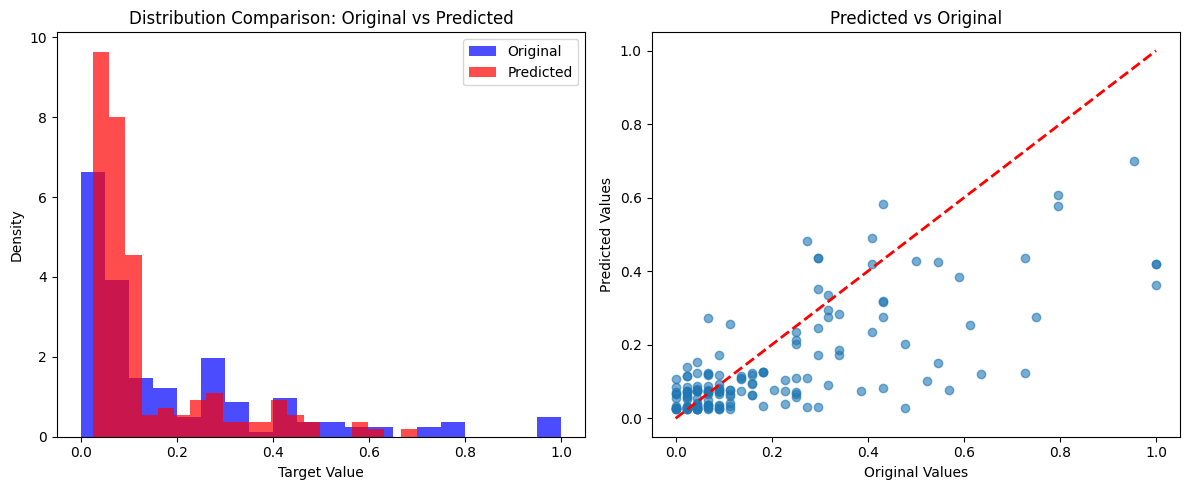


=== Distribution Statistics ===
Original - Mean: 0.1937, Std: 0.2235
Predicted - Mean: 0.1315, Std: 0.1376

=== First 10 Predictions ===
   original  predicted      diff          mape        r2       mae       mse
0  0.159091   0.096479  0.062611  1.773684e+13  0.453124  0.101794  0.027323
1  0.386364   0.073537  0.312826  1.773684e+13  0.453124  0.101794  0.027323
2  0.045455   0.025353  0.020101  1.773684e+13  0.453124  0.101794  0.027323
3  0.090909   0.025255  0.065654  1.773684e+13  0.453124  0.101794  0.027323
4  0.022727   0.025826 -0.003099  1.773684e+13  0.453124  0.101794  0.027323
5  0.068182   0.072510 -0.004328  1.773684e+13  0.453124  0.101794  0.027323
6  0.113636   0.077231  0.036405  1.773684e+13  0.453124  0.101794  0.027323
7  0.431818   0.275268  0.156551  1.773684e+13  0.453124  0.101794  0.027323
8  0.318182   0.090232  0.227950  1.773684e+13  0.453124  0.101794  0.027323
9  0.090909   0.074933  0.015976  1.773684e+13  0.453124  0.101794  0.027323
Bin centers sha

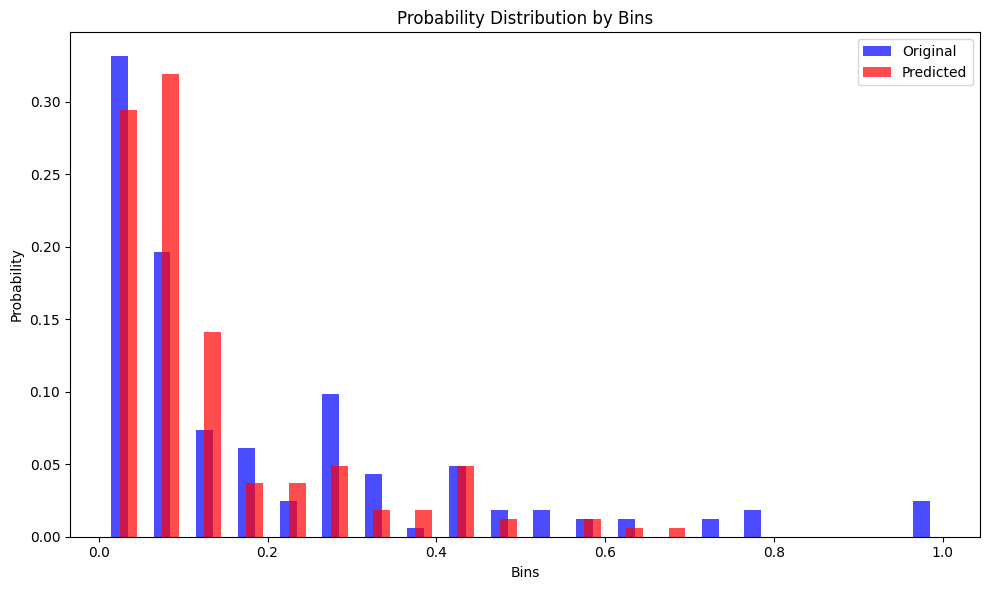

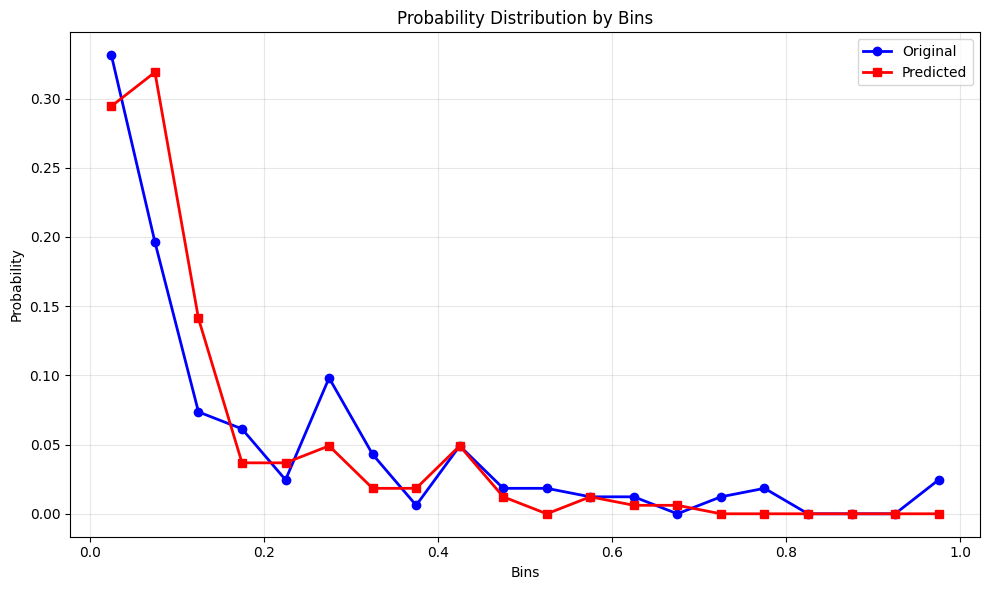

In [ ]:
# Преобразуем в np array
x_train = ensure_numpy(x_train)
x_test = ensure_numpy(x_test)
y_train = ensure_numpy(y_train)
y_test = ensure_numpy(y_test)

x_train_s, x_test_s, scaler = prepare_data(x_train, x_test) 

x_tr, x_val, y_tr, y_val = train_test_split(x_train_s, y_train, test_size=0.15, random_state=42)

print("Shapes after split:", "x_tr", x_tr.shape, "y_tr", y_tr.shape, "x_val", x_val.shape, "y_val", y_val.shape)
assert x_tr.shape[0] == y_tr.shape[0], f"x_tr rows {x_tr.shape[0]} != y_tr rows {y_tr.shape[0]}"
assert x_val.shape[0] == y_val.shape[0]

device = "cuda" if torch.cuda.is_available() else "cpu"

# Биннинг таргета
num_bins = 20 # Количество бинов - классов, на которые мы разделим исходную выборку
bins = np.linspace(y_train.min(), y_train.max(), num_bins+1)

# Преобразуем целевые переменные в индексы бинов и обрежем до правильного диапазона
y_tr_bin = np.digitize(y_tr.flatten(), bins) - 1
y_tr_bin = np.clip(y_tr_bin, 0, num_bins-1)

y_val_bin = np.digitize(y_val.flatten(), bins) - 1
y_val_bin = np.clip(y_val_bin, 0, num_bins-1)

# Частоты для взвешивания классов
# Поскольку мы стремимся максимизировать частоту предсказания, используем веса для функции потерь 
bin_counts = np.bincount(y_tr_bin, minlength=num_bins)
class_weights = 1.0 / (bin_counts**0.5 + 1) # Важно, чтобы порядок минимальной добавки (у нас 1) соответствовала минимумам bin_counts
class_weights = class_weights / class_weights.sum() * num_bins

print(f"Number of bins: {num_bins}")
print(f"Bin counts: {bin_counts}")
print(f"Class weights shape: {class_weights.shape}")
print(f"Class weights: {class_weights}")

# Создаем модель
model = AttentionClassifier(input_dim=x_train_s.shape[1], attention_hidden=attention_hidden, num_bins=num_bins).to(device)

# Подготовка данных для классификации
train_ds = TensorDataset(
    torch.tensor(x_tr, dtype=torch.float32), 
    torch.tensor(y_tr_bin, dtype=torch.long)
)
val_ds = TensorDataset(
    torch.tensor(x_val, dtype=torch.float32), 
    torch.tensor(y_val_bin, dtype=torch.long)
)

# Семплер с весами
weights = class_weights[y_tr_bin]
sampler = torch.utils.data.WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32)

# Обучаем модель
history, bins = train_classifier_model(model, train_loader, val_loader, bins, class_weights, epochs=130, device=device)
print("Training complete. Best model saved to ./artifacts/best_model.pt")

# Проверка на тестовых данных
print("\n=== Testing on Test Set ===")
df_results, test_predictions = load_and_predict_classifier("./artifacts/best_model.pt", x_test_s, y_test, bins, device=device)

# Визуализация распределений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=20, alpha=0.7, label='Original', color='blue', density=True)
plt.hist(test_predictions, bins=20, alpha=0.7, label='Predicted', color='red', density=True)
plt.xlabel('Target Value')
plt.ylabel('Density')
plt.title('Distribution Comparison: Original vs Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, test_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Original')

plt.tight_layout()
plt.savefig("./artifacts/test_results.png")
plt.show()

print("\n=== Distribution Statistics ===")
print(f"Original - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")
print(f"Predicted - Mean: {test_predictions.mean():.4f}, Std: {test_predictions.std():.4f}")

# Выводим первые несколько строк результатов
print("\n=== First 10 Predictions ===")
print(df_results.head(10))

# визуализация распределения по бинам
plt.figure(figsize=(10, 6))

# Распределение оригинальных данных по бинам
original_binned = np.digitize(y_test, bins) - 1
original_binned = np.clip(original_binned, 0, len(bins)-2)

# Распределение предсказаний по бинам
predicted_binned = np.digitize(test_predictions, bins) - 1
predicted_binned = np.clip(predicted_binned, 0, len(bins)-2)

bin_centers = (bins[:-1] + bins[1:]) / 2

# Убедимся, что все массивы одномерные
original_binned = original_binned.flatten()
predicted_binned = predicted_binned.flatten()

# Вычисляем частоты
original_counts = np.bincount(original_binned, minlength=len(bin_centers))
predicted_counts = np.bincount(predicted_binned, minlength=len(bin_centers))

# Нормализуем до вероятностей
original_probs = original_counts / len(y_test)
predicted_probs = predicted_counts / len(test_predictions)

# Убедимся, что все массивы имеют одинаковую длину
print(f"Bin centers shape: {bin_centers.shape}")
print(f"Original probs shape: {original_probs.shape}")
print(f"Predicted probs shape: {predicted_probs.shape}")

# Используем обычный барплот без смещения, если есть проблемы
plt.bar(bin_centers, original_probs, width=np.diff(bins)[0]*0.4, 
        alpha=0.7, label='Original', color='blue', align='center')
plt.bar(bin_centers, predicted_probs, width=np.diff(bins)[0]*0.4,
        alpha=0.7, label='Predicted', color='red', align='edge')

plt.xlabel('Bins')
plt.ylabel('Probability')
plt.title('Probability Distribution by Bins')
plt.legend()
plt.tight_layout()
plt.savefig("./artifacts/bin_distribution.png")
plt.show()

# Альтернативная визуализация - линейный график
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, original_probs, 'o-', label='Original', color='blue', linewidth=2)
plt.plot(bin_centers, predicted_probs, 's-', label='Predicted', color='red', linewidth=2)
plt.xlabel('Bins')
plt.ylabel('Probability')
plt.title('Probability Distribution by Bins')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./artifacts/bin_distribution_line.png")
plt.show()

К сожалению, полученная модель не смогла показать значимых результатов, но позволяет сделать некоторые выводы:  
1. В ходе первых попыток получить эффективную модель регрессии важную роль сыграло добавление аугментированных данных
2. Так же значительных улучшений позволило достичь добавление весов для функции потерь с акцентом на бины с меньшим количеством экземпляров.
3. Ни одна из моделей не выдала результат приближенный к 0.9 В дальнейшем скорее всего потребуется повышать чувствительность модели